In [60]:
import pandas as pd
import psycopg2
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
import matplotlib  
pd.set_option('display.precision', 18) 

conn = psycopg2.connect(
    dbname="degentrading",
    user="postgres",
    password="postgres",
    host="192.168.8.105"
)
cursor = conn.cursor()

query = """WITH SelectedSymbols as(
    WITH DailyRecords AS (
    SELECT mp.id,
       mp.symbol
FROM
    market_pairs mp
JOIN
    ohlcv ON mp.id = ohlcv.market_pair_id
WHERE
    ohlcv.open_time >= (CURRENT_DATE - INTERVAL '365 days')
GROUP BY
    mp.id, mp.symbol
HAVING
    COUNT(DISTINCT ohlcv.open_time) >= 365
)

SELECT
    mp.id,
    mp.symbol,
    AVG(ohlcv.volume) as avg_daily_volume
FROM
    market_pairs mp
JOIN
    ohlcv ON mp.id = ohlcv.market_pair_id
JOIN
    DailyRecords dr ON mp.id = dr.id
WHERE
    ohlcv.timeframe = '1d'
    AND ohlcv.open_time >= '2022-01-01'
    AND (
        mp.symbol NOT LIKE '%UP%'
        AND mp.symbol NOT LIKE '%DOWN%'
        AND mp.symbol NOT LIKE '%BULL%'
        AND mp.symbol NOT LIKE '%BEAR%'
        AND mp.symbol NOT LIKE '%BUSD%'
        AND mp.symbol NOT LIKE '%USDC%'
    ) AND mp.symbol LIKE '%BTC'
GROUP BY
    mp.id, mp.symbol
ORDER BY
    avg_daily_volume DESC limit 50
)
SELECT
    ss.symbol,
    ohlcv.open_time,
    ohlcv.close_price

FROM
    ohlcv
JOIN
    SelectedSymbols ss ON ohlcv.market_pair_id = ss.id
WHERE
    ohlcv.timeframe = '1d'
    AND ohlcv.open_time >= (CURRENT_DATE - INTERVAL '75 days')
ORDER BY
    ss.symbol, ohlcv.open_time DESC;"""


cursor.execute(query)

res = cursor.fetchall()
# Close the database connection
conn.close()




In [49]:
data_dict = {}

# Populate the dictionary
for row in res:
    symbol, open_time, close_price = row
    if symbol not in data_dict:
        data_dict[symbol] = []
    data_dict[symbol].append((open_time, np.float64(close_price)))


In [51]:
data_dict.keys()

dict_keys(['AAVEBTC', 'ADABTC', 'AGIXBTC', 'ALGOBTC', 'APEBTC', 'APTBTC', 'ATOMBTC', 'AVAXBTC', 'AXSBTC', 'BCHBTC', 'BNBBTC', 'CHZBTC', 'CRVBTC', 'DOGEBTC', 'DOTBTC', 'EOSBTC', 'ETCBTC', 'ETHBTC', 'FETBTC', 'FILBTC', 'FTMBTC', 'GALABTC', 'GMTBTC', 'HFTBTC', 'HOOKBTC', 'LINKBTC', 'LRCBTC', 'LTCBTC', 'MAGICBTC', 'MANABTC', 'MATICBTC', 'NEARBTC', 'OAXBTC', 'ONEBTC', 'OPBTC', 'PYRBTC', 'QNTBTC', 'RUNEBTC', 'SANDBTC', 'SOLBTC', 'THETABTC', 'TRXBTC', 'UNIBTC', 'VETBTC', 'WAVESBTC', 'WBTCBTC', 'XLMBTC', 'XMRBTC', 'XRPBTC', 'ZILBTC'])

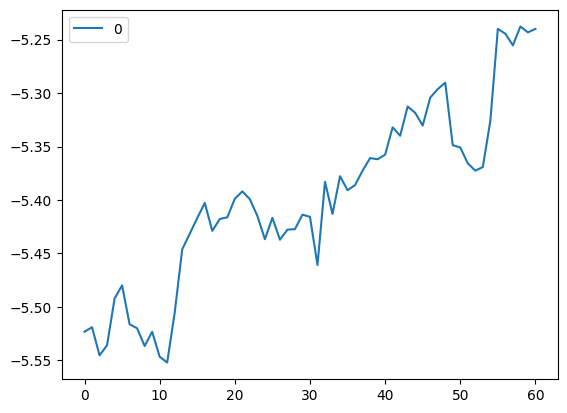

In [69]:
data_dict['AAVEBTC'].sort(key=lambda x: x[0])

pd.DataFrame([np.log(i[1]) for i in data_dict['XMRBTC'][:-14]]).plot()

y = np.array([np.log(i[1]) for i in data_dict['XMRBTC'][:-14]]).reshape(-1, 1)
X = np.array([i for i in range(0, len(y))]).reshape(-1, 1)
reg = LinearRegression().fit(X, y)

In [84]:
scores = []
for k in data_dict.keys():
    y = np.array([np.log(i[1]) for i in data_dict[k][:-14]]).reshape(-1, 1)
    X = np.array([i for i in range(0, len(y))]).reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    slope = reg.coef_[0][0] 
    r2 = reg.score(X, y)
    scores.append((k, reg.coef_[0][0], reg.score(X,y), slope * r2))

In [88]:
scores.sort(key=lambda x:x[3], reverse=True)
scores

[('BCHBTC', 0.00637765651302541, 0.94314130257912, 0.0060150312710969935),
 ('OAXBTC', 0.006482849603824057, 0.8793108277053828, 0.005700439851028045),
 ('XMRBTC', 0.004450493100545875, 0.8488028609911638, 0.003777591276564774),
 ('LTCBTC', 0.003885109034749755, 0.8787567209238735, 0.00341406567580841),
 ('BNBBTC', 0.004293380791377513, 0.72159462805181, 0.003098080515238842),
 ('XLMBTC', 0.0037845609829590746, 0.8101892323189765, 0.003066210557447964),
 ('QNTBTC', 0.0032196079301468426, 0.7546111414864076, 0.002429552015306799),
 ('TRXBTC', 0.0032185506074323745, 0.6459161760894407, 0.002078913900903066),
 ('XRPBTC', 0.003005248760907205, 0.4674949153211896, 0.0014049385149994239),
 ('AAVEBTC',
  0.0020007978706145287,
  0.33918675175232804,
  0.0006786441306467167),
 ('ETCBTC', 0.0007023962039147525, 0.08348537828907454, 5.863981279263305e-05),
 ('WBTCBTC',
  3.386591381609744e-05,
  0.38943652858285993,
  1.3188623913827301e-05),
 ('ZILBTC', 0.0003602341573618675, 0.0310112557919365

<Axes: >

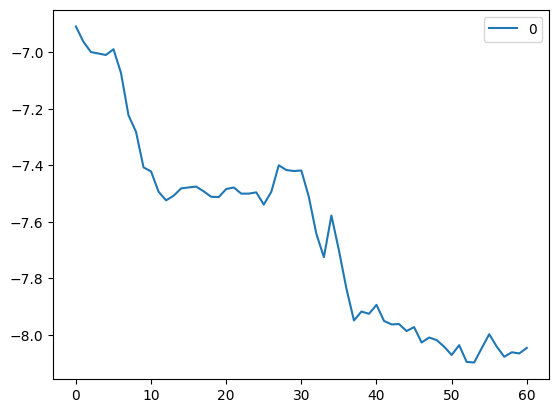

In [92]:
pd.DataFrame([np.log(i[1]) for i in data_dict['AVAXBTC'][:-14]]).plot()